In [1]:
# unzip the file
!tar zxvf cifar100.tar.gz

cifar100/
cifar100/train.pt
cifar100/valid.pt


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import  os
print(os.getcwd()) # 获取当前工作目录路径
print(os.path.abspath('.')) # 获取当前工作目录路径

/msedahome/NVL4/msedalab/s313510164/myenv/DL_Lab5
/msedahome/NVL4/msedalab/s313510164/myenv/DL_Lab5


In [4]:
from network import get_transforms
transform = get_transforms()
train_set = torch.load("cifar100/train.pt")
valid_set = torch.load("cifar100/valid.pt")

batch_size = 32
train_loader = DataLoader(train_set, batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False)

/tmp/ipykernel_2725130/520462855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_set = torch.load("cifar100/train.pt")
/tmp/ipykernel_2725130/520462855.py:2: Futur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0007182956..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4258603..1.4700662].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4185303..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24997896..1.4558628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1912992..0.85081226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4478504..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4258603..1.2941865].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33789986..1.4913714].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.298

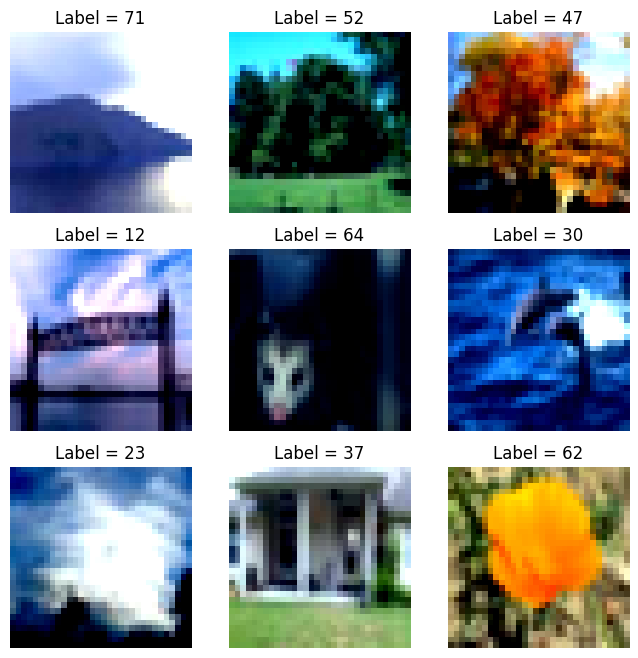

In [5]:
## show the read pictures randomly
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img = train_set[sample_idx][0].numpy().transpose(1, 2, 0)
    label = train_set[sample_idx][1]
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title("Label = {}".format(label))
    plt.axis("off")

    img = img / 2 + 0.5
    
    plt.imshow(img.squeeze())
plt.show()

# Model

In [6]:
import network
from network import *
import multiprocessing as mp  # Added multiprocessing import

# using gpu if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_optimal_workers():
    """Get optimal number of workers based on system CPU count"""
    try:
        cpu_count = mp.cpu_count()
    except:
        # Fallback to 0 workers if cpu_count() fails
        return 0
    # Return minimum of 2 or available CPU cores
    return min(2, cpu_count)

#build your model here

#call model
model = ImprovedCNN(num_classes=100).to(DEVICE)

# 儲存模型
MODEL_PATH = "model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to model.pth


In [7]:
####################  Training Phase  ###################################
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [8]:
####################  Validation Phase  ###################################
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return total_loss / len(val_loader), accuracy

In [9]:

def main():
    # 超参数
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 100

    num_workers = get_optimal_workers()
    
    # 数据加载
    transform = get_transforms()
    
    # 初始化模型
    model = ImprovedCNN(num_classes=100).to(DEVICE)
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    # 训练循环
    best_accuracy = 0
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validate(model, valid_loader, criterion, DEVICE)
        
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        
        # 保存最佳模型
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'model.pth')
    
    print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

if __name__ == "__main__":
    main()

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100
Train Loss: 3.9685, Val Loss: 3.6414, Val Accuracy: 12.41%
Epoch 2/100
Train Loss: 3.5753, Val Loss: 3.4042, Val Accuracy: 16.01%
Epoch 3/100
Train Loss: 3.3661, Val Loss: 3.2111, Val Accuracy: 19.76%
Epoch 4/100
Train Loss: 3.2007, Val Loss: 3.1236, Val Accuracy: 21.76%
Epoch 5/100
Train Loss: 3.0675, Val Loss: 2.9394, Val Accuracy: 25.25%
Epoch 6/100
Train Loss: 2.9686, Val Loss: 2.9011, Val Accuracy: 26.07%
Epoch 7/100
Train Loss: 2.8951, Val Loss: 2.8148, Val Accuracy: 27.38%
Epoch 8/100
Train Loss: 2.8404, Val Loss: 2.7706, Val Accuracy: 28.83%
Epoch 9/100
Train Loss: 2.7755, Val Loss: 2.7718, Val Accuracy: 28.88%
Epoch 10/100
Train Loss: 2.7339, Val Loss: 2.7429, Val Accuracy: 29.07%
Epoch 11/100
Train Loss: 2.6896, Val Loss: 2.5962, Val Accuracy: 32.13%
Epoch 12/100
Train Loss: 2.6508, Val Loss: 2.5757, Val Accuracy: 33.13%
Epoch 13/100
Train Loss: 2.6160, Val Loss: 2.5444, Val Accuracy: 33.6

In [ ]:
%run test.py

/msedahome/NVL4/msedalab/s313510164/myenv/DL_Lab5/network.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEV

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
flops = 7931008
Model parameter size = 328.562 kB


In [12]:
500000000
20000000

20000000